# Importing packages needed for the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install tensorflow==2.11.1

import tensorflow as tf
print(tf.__version__)
# tensorflow version used at development was 2.11.1, tf_io version: 0.31.0, tfp version: 0.19.0
# tensorflow on google colab upgraded to 2.12.0 at March 30. 2023, in middle of this project
# which introduced some compatibility issues, fixing the version at 2.11.1 have no issues.

import torch
print(torch.__version__)
import matplotlib
print(matplotlib.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-serve

2.11.1
2.0.0+cu118
3.7.1


In [3]:
# Other imports
! pip install tensorflow_addons==0.19.0
! pip install tensorflow_io==0.31.0
! pip install tensorflow_probability==0.19.0
! pip install porespy==2.2.2

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import tensorflow_probability as tfp

import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity as kde
from IPython.display import Image, display
import porespy
from edt import edt

tfpl = tfp.layers
tfd = tfp.distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.32.0
    Uninstalling tensorflow-io-gcs-filesystem-0.32.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.32.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Define functions, global parameters and preprocessing

## image preprocessing functions

In [4]:
# Image preprocessing utils
def parse_images_saxs(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[sem_imageSize, sem_imageSize])

    return image

In [5]:
# Image preprocessing utils
def parse_images_saxs_for_mapping_tf_ds(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[sem_imageSize, sem_imageSize])

    return image, image

In [6]:
# Image preprocessing utils
def parse_images_sem_TSNE(image_path):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = image[:sem_imageSize, :sem_imageSize, :]

    return image

In [7]:
# Image preprocessing utils
def parse_images_sem_no_crop(image_path):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = tfa.image.gaussian_filter2d(image, 5)
    image = cv2.cvtColor(image.numpy().astype('float32'), cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image.astype('uint8'), 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adapt_window, 2)
    image = cv2.GaussianBlur(image,(5,5),0)

    return image

In [8]:
# Image preprocessing utils
def parse_images_sem_crop(image_path, left, bottom):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = tfa.image.gaussian_filter2d(image, 5)
    image = cv2.cvtColor(image.numpy().astype('float32'), cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image.astype('uint8'), 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adapt_window, 2)
    image = cv2.GaussianBlur(image,(5,5),0)
    image = image[left:left+sem_imageSize, bottom:bottom+sem_imageSize]

    return image

In [9]:
# Image preprocessing utils
def parse_images_sem_crop_tf_ds(image, left, bottom):
    # if want to see training without random crop: fix to crop upper left corner
    # left = 0
    # bottom = 0
    
    image = image[left:left+sem_imageSize, bottom:bottom+sem_imageSize, :]
    image_2d = image[:, :, 0]

    return image, image_2d

## functions for vae model building

In [10]:
%cd "/content/drive/MyDrive/nanowire-morphology-classification-project"

/content/drive/.shortcut-targets-by-id/1qb_BrPe6oJ2Dg0E6xoFYETWtLHETrwQj/nanowire-morphology-classification-project


In [11]:
def upsample(filters, size, apply_dropout=False):

  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    bias_initializer='he_normal'))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [12]:
# define loss functions and metrics for segmentation task
# coef functions are for batches of images, score functions are for a single image

def dice_coef_2d(y_true, y_pred, smooth=0.000001):
  
    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    fp = tf.reduce_sum(y_pred, axis=[1,2]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2]) - tp

    score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth))
    return score

def dice_coef_3d(y_true, y_pred, smooth=0.000001):
  
    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fp = tf.reduce_sum(y_pred, axis=[1,2,3]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2,3]) - tp

    score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth))
    return score

def dice_score(y_true, y_pred, smooth=0.000001):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  beta = 1
  tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
  fp = tf.reduce_sum(y_pred, axis=[1, 2]) - tp
  fn = tf.reduce_sum(y_true, axis=[1, 2]) - tp

  score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
          / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)).numpy()
  return score

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=0.000001):

    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    fp = tf.reduce_sum(y_pred, axis=[1,2]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2]) - tp

    score = tf.reduce_mean((tp + smooth) \
            / (tp + fn + fp + smooth))
    return score

def iou_score(y_true, y_pred, smooth=0.000001):
  y_true = y_true.astype('float32')
  tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
  fp = tf.reduce_sum(y_pred, axis=[1, 2]) - tp
  fn = tf.reduce_sum(y_true, axis=[1, 2]) - tp

  score = tf.reduce_mean((tp + smooth) \
          / (tp + fn + fp + smooth)).numpy()
  return score

def iou_coef_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

def softmax_loss(y_true, y_pred):
  softmax_loss = tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred, axis=[1, 2, 3])
  return softmax_loss

In [13]:
def saxs_encoder(shape, feature_extractor_model, num_features, prior, kl_weight):
  inputs = Input(shape)

  x = feature_extractor_model(inputs)

  x = Dense(num_features, activation='relu', kernel_initializer='random_normal')(x)
  
  # x = AveragePooling2D((2,2))(x)

  encoded_size = x.shape[-1]
  
  # options for distribution: IndependentNormal or MultivariateNormalTriL
  x = Dense(tfpl.IndependentNormal.params_size(encoded_size), activation=None)(x)
  x = tfpl.IndependentNormal(encoded_size, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight))(x)
  return Model(inputs=inputs, outputs=x)

In [14]:
def saxs_decoder(shape, num_filter, filter_size):
  inputs = Input(shape)

  x = inputs

  upsampling_block = [
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    # upsample(num_filter, filter_size),
  ]

  # x = Reshape((1, 1, x.shape[-1]))(x)

  for up in upsampling_block:
    x = up(x)
  
  last = Conv2DTranspose(3, filter_size,    # number of class, size of input vector (batch_size, x, y, class)
                              strides=2,
                              padding='same',
                              bias_initializer='he_normal',
                              kernel_initializer='he_normal',
                              activation='sigmoid')       # (batch_size, resolution, resolution, 3)
                              # sigmoid activation transforms values to between 0 and 1
  
  x = last(x)
  # Bernoulli distribution for the recreated image, for it's binary. () means we don't want the third dimension. We want (imageSize, imageSize)
  # x = tfpl.IndependentBernoulli((), convert_to_tensor_fn=tfd.Distribution.mode)(x)

  return Model(inputs=inputs, outputs=x)

In [15]:
def sem_encoder(shape, feature_extractor_model, num_features, prior, kl_weight):
  inputs = Input(shape)

  x = feature_extractor_model(inputs)

  x = Dense(num_features, activation='relu', kernel_initializer='random_normal')(x)
  
  # x = AveragePooling2D((2,2))(x)

  encoded_size = x.shape[-1]
  
  # options for distribution: IndependentNormal or MultivariateNormalTriL
  x = Dense(tfpl.IndependentNormal.params_size(encoded_size), activation=None)(x)
  x = tfpl.IndependentNormal(encoded_size, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight))(x)
  return Model(inputs=inputs, outputs=x)

In [16]:
def sem_decoder(shape, num_filter, filter_size):
  inputs = Input(shape)

  x = inputs

  upsampling_block = [
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    # upsample(num_filter, filter_size),
  ]

  # x = Reshape((1, 1, x.shape[-1]))(x)

  for up in upsampling_block:
    x = up(x)
  
  last = Conv2DTranspose(num_filter, filter_size,    # size of input vector (batch_size, x, y, num_filter)
                              strides=2,
                              padding='same',
                              bias_initializer='he_normal',
                              kernel_initializer='he_normal',
                              activation=None)
                              # no activation here because we are use logits directly in the Bernoulli layer, 
                              # and the Bernoulli layer will act as an activation layer
  
  x = last(x)
  x = tf.reduce_mean(x, axis=-1, keepdims=True)

  # Bernoulli distribution for the recreated image, for it's binary. () means we don't want the third dimension. We want (imageSize, imageSize)
  x = tfpl.IndependentBernoulli((), convert_to_tensor_fn=tfd.Distribution.mode)(x)

  return Model(inputs=inputs, outputs=x)

In [17]:
def get_pretrained_image_encoder_model(Resnet50_backbone, imagesize, hidden_1, hidden_2, hidden_3):
    base_model = Resnet50_backbone
    base_model.trainable = True
    inputs = Input((imagesize, imagesize, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)                                        
    projection_1 = Activation("relu")(projection_1)
    projection_1 = BatchNormalization(epsilon=0.001)(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_2 = BatchNormalization(epsilon=0.001)(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)
    projection_3 = BatchNormalization(epsilon=0.001)(projection_3)

    resnet_model = Model(inputs, projection_3)
    
    return resnet_model

## global hyperparamters

In [18]:
random_seed = 43
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

training_batch_size = 8

# cropped image size for both saxs and sem images
saxs_imageSize = 192
sem_imageSize = 192

train_ratio = 6 / 9

# size of the latent space for both autoencoders
latent_space_num_filters = 32

# sem image without the bottom part
sem_original_x_length = 830
sem_original_y_length = 1280

# window size for adaptive thresholding
adapt_window = 15

In [19]:
rng = np.random.default_rng(seed=random_seed)

sem_image_path = "/content/drive/MyDrive/TEM image datasets/2023-Sci-Adv-SAXS-SEM/SEM"
sem_image_file_list = list(paths.list_files(basePath=sem_image_path, validExts='tif'))
sem_image_file_list.sort()
sem_image_file_list = np.array(sem_image_file_list)
saxs_image_path = "/content/drive/MyDrive/TEM image datasets/2023-Sci-Adv-SAXS-SEM/SAXS"
saxs_image_file_list = list(paths.list_files(basePath=saxs_image_path, validExts='jpg'))
saxs_image_file_list.sort()
saxs_image_file_list = np.array(saxs_image_file_list)

sem_image_whole_holder = np.zeros((len(sem_image_file_list), sem_original_x_length, sem_original_y_length, 3))
sem_image_whole_2d_holder = np.zeros((len(sem_image_file_list), sem_original_x_length, sem_original_y_length))
sem_image_holder = np.zeros((len(sem_image_file_list), sem_imageSize, sem_imageSize, 3))
sem_image_2d_holder = np.zeros((len(sem_image_file_list), sem_imageSize, sem_imageSize))
for i in range(len(sem_image_file_list)):
  sem_image_2d_holder[i] = parse_images_sem_crop(sem_image_file_list[i], rng.integers(0, sem_original_x_length - sem_imageSize), rng.integers(0, sem_original_y_length - sem_imageSize))
  sem_image_whole_2d_holder[i] = parse_images_sem_no_crop(sem_image_file_list[i])
  sem_image_holder[i] = np.stack((sem_image_2d_holder[i], sem_image_2d_holder[i], sem_image_2d_holder[i]), axis=-1)
  sem_image_whole_holder[i] = np.stack((sem_image_whole_2d_holder[i], sem_image_whole_2d_holder[i], sem_image_whole_2d_holder[i]), axis=-1)

saxs_image_holder = np.zeros((len(saxs_image_file_list), saxs_imageSize, saxs_imageSize, 3))
for i in range(len(saxs_image_file_list)):
  saxs_image_holder[i] = parse_images_saxs(saxs_image_file_list[i])

IDs = np.arange(len(sem_image_file_list))

train_IDs = rng.choice(IDs, np.rint(len(IDs) * train_ratio).astype(int), replace=False, shuffle=True)
saxs_image_train_file_list = saxs_image_file_list[train_IDs]
sem_image_train_file_list = sem_image_file_list[train_IDs]
saxs_image_train = saxs_image_holder[train_IDs]
sem_image_train = sem_image_holder[train_IDs]
sem_image_whole_train = sem_image_whole_holder[train_IDs]
sem_image_train_2d = sem_image_2d_holder[train_IDs]
sem_image_whole_train_2d = sem_image_whole_2d_holder[train_IDs]

minus_training_IDs = np.delete(IDs, train_IDs)
validation_IDs = rng.choice(minus_training_IDs, np.rint(len(IDs) * (1 - train_ratio)).astype(int), replace=False, shuffle=True)
saxs_image_validation_file_list = saxs_image_file_list[validation_IDs]
sem_image_validation_file_list = sem_image_file_list[validation_IDs]
saxs_image_validation = saxs_image_holder[validation_IDs]
sem_image_validation = sem_image_holder[validation_IDs]
sem_image_validation_2d = sem_image_2d_holder[validation_IDs]
sem_image_whole_validation = sem_image_whole_holder[validation_IDs]
sem_image_whole_validation_2d = sem_image_whole_2d_holder[validation_IDs]

## examples of saxs and sem figures

In [ ]:
for i in range(24):
  plt.figure()
  plt.imshow(sem_image_whole_validation[i].astype('uint8'))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(24):
  plt.figure()
  plt.imshow(saxs_image_validation[i], cmap='gray')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# raw sem images with no preprocessing
for i in range(24):
  plt.figure()
  plt.imshow(sem_image_validation_2d[i], cmap='gray')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# preprocessing with gaussian blur, adaptive thresholding
for i in range(24):
  plt.figure()
  plt.imshow(sem_image_validation_2d[i], cmap='gray')
  plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

## get Resnet50 model and prepare tf datasets

In [53]:
Resnet50_transfer_sem = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(sem_imageSize, sem_imageSize, 3), 
    pooling=None,
)

Resnet50_transfer_saxs = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(saxs_imageSize, saxs_imageSize, 3), 
    pooling=None,
)

Resnet50_transfer_sem.trainable = False
Resnet50_transfer_saxs.trainable = False

In [21]:
sem_training_ds = tf.data.Dataset.from_tensor_slices(sem_image_whole_train)
sem_training_ds = (
    sem_training_ds
    .map(lambda x: parse_images_sem_crop_tf_ds(x, tf.random.uniform(shape=[], minval=0, maxval=sem_original_x_length - sem_imageSize, dtype=tf.int32), tf.random.uniform(shape=[], minval=0, maxval=sem_original_y_length - sem_imageSize, dtype=tf.int32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

sem_validation_ds = tf.data.Dataset.from_tensor_slices(sem_image_whole_validation)
sem_validation_ds = (
    sem_validation_ds
    .map(lambda x: parse_images_sem_crop_tf_ds(x, tf.random.uniform(shape=[], minval=0, maxval=sem_original_x_length - sem_imageSize, dtype=tf.int32), tf.random.uniform(shape=[], minval=0, maxval=sem_original_y_length - sem_imageSize, dtype=tf.int32)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

saxs_training_ds = tf.data.Dataset.from_tensor_slices(saxs_image_train_file_list)
saxs_training_ds = (
    saxs_training_ds
    .map(parse_images_saxs_for_mapping_tf_ds, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

saxs_validation_ds = tf.data.Dataset.from_tensor_slices(saxs_image_validation_file_list)
saxs_validation_ds = (
    saxs_validation_ds
    .map(parse_images_saxs_for_mapping_tf_ds, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

sem_training_ds_no_crop = tf.data.Dataset.from_tensor_slices(sem_image_whole_train)
sem_training_ds_no_crop = (
    sem_training_ds_no_crop
    .batch(training_batch_size
           , drop_remainder=True
           )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# VAE solo training

## VAE solo training for SAXS and for SEM

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/solo_trained_models/'

num_filter = 8
filter_size = 5
prior_mean = 0
prior_variance = 1
saxs_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])
n_epoch = np.array([500])

In [62]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_saxs, saxs_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

saxs_encoded_size = [saxs_imageSize // 32, saxs_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
saxs_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(saxs_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_saxs_encoder = saxs_encoder((saxs_imageSize, saxs_imageSize, 3), trained_resnet50, latent_space_num_filters, saxs_prior, saxs_kl_weight)

vae_saxs_decoder = saxs_decoder(saxs_encoded_size, num_filter, filter_size)

saxs_vae = Model(inputs=vae_saxs_encoder.inputs, outputs=vae_saxs_decoder(vae_saxs_encoder.outputs[0]))

saxs_vae.compile(optimizer=optimizer, loss='mse', metrics='mae')
model_history = saxs_vae.fit(x=saxs_training_ds, epochs=n_epoch[0], 
        batch_size=training_batch_size, validation_data=(saxs_validation_ds))

# save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize%i_seed%i.h5' % (saxs_imageSize, adapt_window, latent_space_num_filters, saxs_image_train.shape[0], random_seed)
# vae_saxs_encoder.save_weights(mother_directory + 'saxs_encoder_' + save_file_name)
# vae_saxs_decoder.save_weights(mother_directory + 'saxs_decoder_' + save_file_name)

Epoch 1/500


5/6 [========================>.....] - ETA: 0s - loss: 16.1289 - mae: 0.4488

6/6 [==============================] - 8s 291ms/step - loss: 14.1614 - mae: 0.4465 - val_loss: 3.1731 - val_mae: 0.4724
Epoch 2/500
6/6 [==============================] - 0s 51ms/step - loss: 1.4833 - mae: 0.4194 - val_loss: 0.5928 - val_mae: 0.4678
Epoch 3/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4892 - mae: 0.3950 - val_loss: 0.5017 - val_mae: 0.4630
Epoch 4/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4406 - mae: 0.3714 - val_loss: 0.5011 - val_mae: 0.4581
Epoch 5/500
6/6 [==============================] - 0s 49ms/step - loss: 0.4036 - mae: 0.3482 - val_loss: 0.4923 - val_mae: 0.4525
Epoch 6/500
6/6 [==============================] - 0s 49ms/step - loss: 0.3856 - mae: 0.3258 - val_loss: 0.4836 - val_mae: 0.4460
Epoch 7/500
6/6 [==============================] - 0s 48ms/step - loss: 0.3553 - mae: 0.3042 - val_loss: 0.4765 - val_mae: 0.4382
Epoch 8/500
6/6 [==============================] - 0s 48ms/step - loss: 0.3436 - mae: 0.2834 - val_l

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/solo_trained_models/'

num_filter = 32
filter_size = 15
prior_mean = 0
prior_variance = 1
sem_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])
n_epoch = np.array([1000])

In [66]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_sem, sem_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

sem_encoded_size = [sem_imageSize // 32, sem_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
sem_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(sem_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_sem_encoder = sem_encoder((sem_imageSize, sem_imageSize, 3), trained_resnet50, latent_space_num_filters, sem_prior, sem_kl_weight)

vae_sem_decoder = sem_decoder(sem_encoded_size, num_filter, filter_size)

sem_vae = Model(inputs=vae_sem_encoder.inputs, outputs=vae_sem_decoder(vae_sem_encoder.outputs[0]))

sem_vae.compile(optimizer=optimizer, loss=negative_log_likelihood, metrics=dice_coef_2d)
model_history = sem_vae.fit(sem_training_ds, epochs=n_epoch[0], 
        batch_size=training_batch_size, validation_data=[sem_validation_ds])

save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize%i_seed%i.h5' % (sem_imageSize, adapt_window, latent_space_num_filters, sem_image_train.shape[0], random_seed)
vae_sem_encoder.save_weights(mother_directory + 'sem_encoder_' + save_file_name)
vae_sem_decoder.save_weights(mother_directory + 'sem_decoder_' + save_file_name)

Epoch 1/1000


6/6 [==============================] - ETA: 0s - loss: 0.7103 - dice_coef_2d: 0.4367

6/6 [==============================] - 9s 373ms/step - loss: 0.7103 - dice_coef_2d: 0.4367 - val_loss: 0.6952 - val_dice_coef_2d: 0.4643
Epoch 2/1000
6/6 [==============================] - 1s 96ms/step - loss: 0.6953 - dice_coef_2d: 0.3331 - val_loss: 0.7303 - val_dice_coef_2d: 0.4815
Epoch 3/1000
6/6 [==============================] - 1s 96ms/step - loss: 0.6936 - dice_coef_2d: 0.1970 - val_loss: 1.8472 - val_dice_coef_2d: 0.5404
Epoch 4/1000
6/6 [==============================] - 1s 96ms/step - loss: 0.6924 - dice_coef_2d: 0.1615 - val_loss: 3.0972 - val_dice_coef_2d: 0.6419
Epoch 5/1000
6/6 [==============================] - 1s 97ms/step - loss: 0.6914 - dice_coef_2d: 0.2191 - val_loss: 1.4612 - val_dice_coef_2d: 0.6178
Epoch 6/1000
6/6 [==============================] - 1s 96ms/step - loss: 0.6910 - dice_coef_2d: 0.1441 - val_loss: 0.7960 - val_dice_coef_2d: 0.5031
Epoch 7/1000
6/6 [==============================] - 1s 97ms/step - loss: 0.6903 - dice_coef_2d: 0.2072 - val_loss: 0.8

In [ ]:
image_stack = saxs_vae(saxs_image_validation[:20])

image_index = 7

plt.imshow(image_stack[image_index], cmap='gray')

plt.figure()
plt.imshow(saxs_image_validation[image_index], cmap='gray')

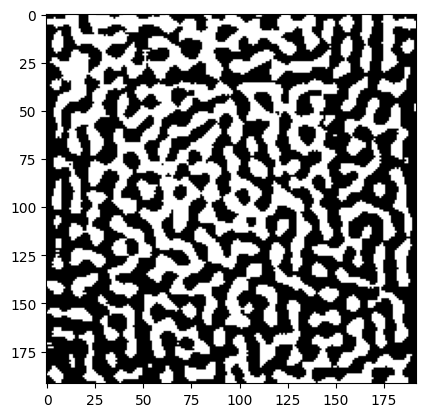

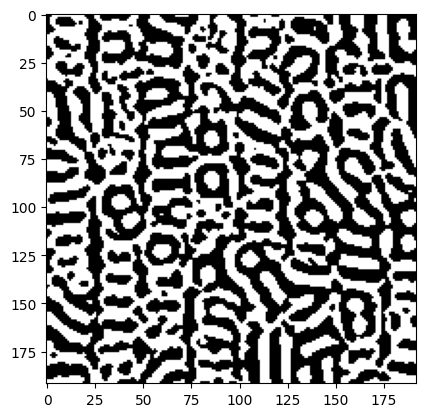

In [ ]:
image_stack = sem_vae(sem_image_validation[:20])

image_index = 5

plt.imshow(image_stack[image_index], cmap='gray')

plt.figure()
plt.imshow(sem_image_validation_2d[image_index], cmap='gray')
# dice_score(image_stack[image_index].numpy(), sem_image_validation_2d[image_index])

## TSNE of solo trained latents

In [ ]:
def visualize_scatter_with_saxs_images(X_2d_data, images_directory, ax, image_zoom=1, boxthickness=2):

    for xy, i in zip(X_2d_data, images_directory):
        x0, y0 = xy
        img = parse_images_saxs(i)
        img = OffsetImage(img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True, pad=1)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)

In [ ]:
def visualize_scatter_with_sem_images(X_2d_data, images_directory, ax, image_zoom=1, boxthickness=2):

    for xy, i in zip(X_2d_data, images_directory):
        x0, y0 = xy
        img = parse_images_sem_TSNE(i)
        img = OffsetImage(img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=True, pad=1)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)

In [ ]:
solo_sem_latent = vae_sem_encoder.predict(sem_image_holder, batch_size=4)
solo_saxs_latent = vae_saxs_encoder.predict(saxs_image_holder, batch_size=4)

solo_sem_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(np.reshape(solo_sem_latent, (solo_sem_latent.shape[0], solo_sem_latent.shape[1] * solo_sem_latent.shape[2] * solo_sem_latent.shape[3])))
solo_saxs_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(np.reshape(solo_saxs_latent, (solo_saxs_latent.shape[0], solo_saxs_latent.shape[1] * solo_saxs_latent.shape[2] * solo_saxs_latent.shape[3])))

In [ ]:
# plot the tsne plot with saxs images
fig, ax = plt.subplots(figsize=(60, 60))
artists = []

visualize_scatter_with_saxs_images(solo_saxs_tsne, saxs_image_file_list, ax, image_zoom=1.00, boxthickness=8)

ax.autoscale()
plt.show()

# plot the tsne plot with cropped sem images (upper left corner (sem_imageSize, sem_imageSize))
fig, ax = plt.subplots(figsize=(60, 60))
artists = []

visualize_scatter_with_sem_images(solo_sem_tsne, sem_image_file_list, ax, image_zoom=1.00, boxthickness=8)

ax.autoscale()
plt.show()

# Paired SAXS-SEM training

## load solo trained SAXS and SEM VAEs

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

num_filter = 8
filter_size = 5
prior_mean = 0
prior_variance = 1
saxs_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])
n_epoch = np.array([500])

In [42]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_saxs, saxs_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

saxs_encoded_size = [saxs_imageSize // 32, saxs_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
saxs_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(saxs_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_saxs_encoder = saxs_encoder((saxs_imageSize, saxs_imageSize, 3), trained_resnet50, latent_space_num_filters, saxs_prior, saxs_kl_weight)

vae_saxs_decoder = saxs_decoder(saxs_encoded_size, num_filter, filter_size)

saxs_vae = Model(inputs=vae_saxs_encoder.inputs, outputs=vae_saxs_decoder(vae_saxs_encoder.outputs[0]))

saxs_vae.compile(optimizer=optimizer, loss='mse', metrics='mae')

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

num_filter = 32
filter_size = 15
prior_mean = 0
prior_variance = 1
sem_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])
n_epoch = np.array([400])

In [44]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_sem, sem_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

sem_encoded_size = [sem_imageSize // 32, sem_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
sem_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(sem_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_sem_encoder = sem_encoder((sem_imageSize, sem_imageSize, 3), trained_resnet50, latent_space_num_filters, sem_prior, sem_kl_weight)

vae_sem_decoder = sem_decoder(sem_encoded_size, num_filter, filter_size)

sem_vae = Model(inputs=vae_sem_encoder.inputs, outputs=vae_sem_decoder(vae_sem_encoder.outputs[0]))

sem_vae.compile(optimizer=optimizer, loss=negative_log_likelihood, metrics=dice_coef_2d)

In [45]:
mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/solo_trained_models/'
save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize%i_seed%i.h5' % (saxs_imageSize, adapt_window, latent_space_num_filters, saxs_image_train.shape[0], random_seed)

vae_saxs_encoder.load_weights(mother_directory + 'saxs_encoder_' + save_file_name)
vae_saxs_decoder.load_weights(mother_directory + 'saxs_decoder_' + save_file_name)
vae_sem_encoder.load_weights(mother_directory + 'sem_encoder_' + save_file_name)
vae_sem_decoder.load_weights(mother_directory + 'sem_decoder_' + save_file_name)

## functions for paired training

In [70]:
#### use this train_step block for Simclr implementation

# tf.config.run_functions_eagerly(False)

@tf.function
def paired_saxs_sem_train_step_simclr(saxs_input, sem_input, sem_target, vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, vae_sem_decoder, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        
        saxs_latent = vae_saxs_encoder(saxs_input)
        saxs_latent_flatten = Flatten()(saxs_latent)
        sem_latent = vae_sem_encoder(sem_input)
        sem_latent_flatten = Flatten()(sem_latent)

        # simclr derivatives uses layer norm
        # normalize projection feature vectors            along the feature dimension, this is a l2_norm
        normalized_saxs_latent = tf.math.l2_normalize(saxs_latent_flatten, axis=1)
        normalized_sem_latent = tf.math.l2_normalize(sem_latent_flatten, axis=1)
        similarities = (tf.matmul(normalized_saxs_latent, normalized_sem_latent, transpose_b=True) / temperature)

        # the temperature-scaled similarities are used as logits for cross-entropy
        contrastive_labels = tf.range(training_batch_size)

        sim_loss = criterion(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0))

        # reconstruction loss measured by negative log likelihood directly from the tensorflow probability layer functionality
        saxs_saxs_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(saxs_input, vae_saxs_decoder(saxs_latent)))
        saxs_sem_loss = tf.reduce_mean(negative_log_likelihood(sem_target, vae_sem_decoder(saxs_latent)))
        sem_sem_loss = tf.reduce_mean(negative_log_likelihood(sem_target, vae_sem_decoder(sem_latent)))
        sem_saxs_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(saxs_input, vae_saxs_decoder(sem_latent)))

        loss = sim_loss * sim_weight + saxs_saxs_loss * saxs_saxs_weight + saxs_sem_loss * saxs_sem_weight + sem_sem_loss * sem_sem_weight + sem_saxs_loss * sem_saxs_weight

    gradients = tape.gradient(loss, vae_saxs_encoder.trainable_variables + vae_saxs_decoder.trainable_variables + vae_sem_encoder.trainable_variables + vae_sem_decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae_saxs_encoder.trainable_variables + vae_saxs_decoder.trainable_variables + vae_sem_encoder.trainable_variables + vae_sem_decoder.trainable_variables))

    return sim_loss, saxs_saxs_loss, saxs_sem_loss, sem_sem_loss, sem_saxs_loss

In [71]:
#### use this train_step block for Barlow-Twins implementation

# tf.config.run_functions_eagerly(True)

@tf.function
def paired_saxs_sem_train_step_barlow(saxs_input, sem_input, sem_target, vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, vae_sem_decoder, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, optimizer, criterion):
    with tf.GradientTape() as tape:

        saxs_latent = vae_saxs_encoder(saxs_input)
        saxs_latent_flatten = Flatten()(saxs_latent)
        sem_latent = vae_sem_encoder(sem_input)
        sem_latent_flatten = Flatten()(sem_latent)

        # batchnorm for barlow twins
        # use these two lines when doing mini-batch gradient descent
        normalized_saxs_latent = (saxs_latent_flatten - tf.reduce_mean(saxs_latent_flatten, axis=0)) / tf.math.reduce_std(saxs_latent_flatten, axis=0)
        normalized_sem_latent = (sem_latent_flatten - tf.reduce_mean(sem_latent_flatten, axis=0)) / tf.math.reduce_std(sem_latent_flatten, axis=0)

        # the cross correlation of image representations should be the identity matrix
        feature_dim = tf.cast(tf.shape(normalized_saxs_latent)[1], tf.float32)
        cross_correlation = (tf.matmul(normalized_saxs_latent, normalized_sem_latent, transpose_a=True) / training_batch_size)
        target_cross_correlation = tf.eye(feature_dim)
        squared_errors = (target_cross_correlation - cross_correlation) ** 2

        # invariance loss = average diagonal error
        # redundancy reduction loss = average off-diagonal error
        invariance_loss = (tf.reduce_sum(squared_errors * tf.eye(feature_dim)) / feature_dim)
        redundancy_reduction_loss = tf.reduce_sum(squared_errors * (1 - tf.eye(feature_dim))) / (feature_dim * (feature_dim - 1))

        # use redundancy_redunction_weight of 0.005 from the paper, not a sensitive parameter
        sim_loss = invariance_loss + 0.005 * redundancy_reduction_loss

        # reconstruction loss measured by negative log likelihood directly from the tensorflow probability layer functionality
        saxs_saxs_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(saxs_input, vae_saxs_decoder(saxs_latent)))
        saxs_sem_loss = tf.reduce_mean(negative_log_likelihood(sem_target, vae_sem_decoder(saxs_latent)))
        sem_sem_loss = tf.reduce_mean(negative_log_likelihood(sem_target, vae_sem_decoder(sem_latent)))
        sem_saxs_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(saxs_input, vae_saxs_decoder(sem_latent)))

        loss = sim_loss * sim_weight + saxs_saxs_loss * saxs_saxs_weight + saxs_sem_loss * saxs_sem_weight + sem_sem_loss * sem_sem_weight + sem_saxs_loss * sem_saxs_weight

    gradients = tape.gradient(loss, vae_saxs_encoder.trainable_variables + vae_saxs_decoder.trainable_variables + vae_sem_encoder.trainable_variables + vae_sem_decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae_saxs_encoder.trainable_variables + vae_saxs_decoder.trainable_variables + vae_sem_encoder.trainable_variables + vae_sem_decoder.trainable_variables))

    return sim_loss, saxs_saxs_loss, saxs_sem_loss, sem_sem_loss, sem_saxs_loss

In [72]:
def paired_saxs_sem_training(method, vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, vae_sem_decoder, saxs_dataset, sem_dataset, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, optimizer, criterion,
                 epochs, random_crop_period, focused_session_epochs, temperature):
    epoch_wise_sim_loss = []
    epoch_wise_saxs_saxs_loss = []
    epoch_wise_saxs_sem_loss = []
    epoch_wise_sem_sem_loss = []
    epoch_wise_sem_saxs_loss = []

    epoch = 1
    for k in tqdm(range(epochs)):
      step_wise_sim_loss = []
      step_wise_saxs_saxs_loss = []
      step_wise_saxs_sem_loss = []
      step_wise_sem_sem_loss = []
      step_wise_sem_saxs_loss = []

      if (epoch - 1) % random_crop_period == 0 and (epoch - 1) <= (epochs - focused_session_epochs):
        left =  tf.random.uniform(shape=[], minval=0, maxval=sem_original_x_length - sem_imageSize, dtype=tf.int32)
        right = left + sem_imageSize
        bottom =  tf.random.uniform(shape=[], minval=0, maxval=sem_original_y_length - sem_imageSize, dtype=tf.int32)
        top = bottom + sem_imageSize

      for saxs_input_batch, sem_input_batch in zip(saxs_dataset, sem_dataset):

          sem_input_list = []
          sem_target_list = []

          for j in range(training_batch_size):
            image_holder = sem_input_batch[j, left:right, bottom:top, :]
            image_holder_2d = image_holder[:, :, 0]
            sem_input_list.append(image_holder)
            sem_target_list.append(image_holder_2d)
          sem_input = tf.stack(sem_input_list)
          sem_target = tf.stack(sem_target_list)

          if method == 'simclr':
            sim_loss, saxs_saxs_loss, saxs_sem_loss, sem_sem_loss, sem_saxs_loss = paired_saxs_sem_train_step_simclr(saxs_input_batch[0], sem_input, sem_target,
                                     vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, 
                                     vae_sem_decoder, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, optimizer, criterion, temperature)
          if method == 'barlow':
            sim_loss, saxs_saxs_loss, saxs_sem_loss, sem_sem_loss, sem_saxs_loss = paired_saxs_sem_train_step_barlow(saxs_input_batch[0], sem_input, sem_target,
                                     vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, 
                                     vae_sem_decoder, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, optimizer, criterion)
          step_wise_sim_loss.append(sim_loss)
          step_wise_saxs_saxs_loss.append(saxs_saxs_loss)
          step_wise_saxs_sem_loss.append(saxs_sem_loss)
          step_wise_sem_sem_loss.append(sem_sem_loss)
          step_wise_sem_saxs_loss.append(sem_saxs_loss)

      epoch_wise_sim_loss.append(np.mean(step_wise_sim_loss))
      epoch_wise_saxs_saxs_loss.append(np.mean(step_wise_saxs_saxs_loss))
      epoch_wise_saxs_sem_loss.append(np.mean(step_wise_saxs_sem_loss))
      epoch_wise_sem_sem_loss.append(np.mean(step_wise_sem_sem_loss))
      epoch_wise_sem_saxs_loss.append(np.mean(step_wise_sem_saxs_loss))

      if epoch % 2 == 0:
        print("epoch: %i sim_loss: %1.4f saxs_saxs_loss: %1.4f saxs_sem_loss: %1.3f sem_sem_loss: %1.3f sem_saxs_loss: %1.4f" %(epoch, epoch_wise_sim_loss[epoch - 1], epoch_wise_saxs_saxs_loss[epoch - 1], epoch_wise_saxs_sem_loss[epoch - 1], epoch_wise_sem_sem_loss[epoch - 1], epoch_wise_sem_saxs_loss[epoch - 1]))
      epoch += 1

    return epoch_wise_sim_loss, epoch_wise_saxs_saxs_loss, epoch_wise_saxs_sem_loss, epoch_wise_sem_sem_loss, epoch_wise_sem_saxs_loss

## training

In [73]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 

epochs = 1100
random_crop_period = 1
focused_session_period = 1000

# random crop epochs = epochs - focused_session_period

# the learning rate decay schedule in the original implementation of SimCLR and Barlow-Twins (not used here)
decay_steps = 4000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=decay_steps)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

method = 'barlow'

sim_weight = 5e-3
saxs_saxs_weight = 4e-2
saxs_sem_weight = 4e-1
sem_sem_weight = 4e-2
sem_saxs_weight = 1e0

In [ ]:
# note: for paired training, for SEM dataset, use the tf dataset with mapping image parse function without cropping, but do random cropping in the training step function
# reason is that as paired training is a custom training loop, the tf dataset with random cropping mapping image parse function will only be applied once at start of the training
# since all epochs are in the training function, so the same cropped dataset is applied for entire training (all epochs).
# this is different than using the default model.fit() training (used for solo vae training), where tf dataset mapping function (random crop) is applied every epoch.

sim_loss, saxs_saxs_loss, saxs_sem_loss, sem_sem_loss, sem_saxs_loss = paired_saxs_sem_training(method, vae_saxs_encoder, vae_saxs_decoder, vae_sem_encoder, vae_sem_decoder, 
                                         saxs_training_ds, sem_training_ds_no_crop, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight,
                                         optimizer, criterion, epochs, random_crop_period, focused_session_period, temperature=0.1)

In [ ]:
# save pair-trained VAE weights
mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/pair_trained_models/'

save_file_name = 'ten_random_crop_cropSize%i_windowSize%i_latentSize%i_trainSize%i_%s_%0.0e_%0.0e_%0.0e_%0.0e_%0.0e_seed%i' \
% (sem_imageSize, adapt_window, latent_space_num_filters, sem_image_train.shape[0], method, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, random_seed)

vae_saxs_encoder.save_weights(mother_directory + 'saxs_encoder_' + save_file_name + '.h5')
vae_saxs_decoder.save_weights(mother_directory + 'saxs_decoder_' + save_file_name + '.h5')
vae_sem_encoder.save_weights(mother_directory + 'sem_encoder_' + save_file_name + '.h5')
vae_sem_decoder.save_weights(mother_directory + 'sem_decoder_' + save_file_name + '.h5')
np.savez_compressed(mother_directory + 'training_loss_' + save_file_name + '.npz', sim_loss=sim_loss, saxs_saxs_loss=saxs_saxs_loss, saxs_sem_loss=saxs_sem_loss, sem_sem_loss=sem_sem_loss, sem_saxs_loss=sem_saxs_loss)

In [ ]:
# load pair-trained VAE weights
mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/pair_trained_models/'

save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize%i_%s_%0.0e_%0.0e_%0.0e_%0.0e_%0.0e_seed%i' \
% (sem_imageSize, adapt_window, latent_space_num_filters, sem_image_train.shape[0], method, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight, random_seed)

vae_saxs_encoder.load_weights(mother_directory + 'saxs_encoder_' + save_file_name + '.h5')
vae_saxs_decoder.load_weights(mother_directory + 'saxs_decoder_' + save_file_name + '.h5')
vae_sem_encoder.load_weights(mother_directory + 'sem_encoder_' + save_file_name + '.h5')
vae_sem_decoder.load_weights(mother_directory + 'sem_decoder_' + save_file_name + '.h5')

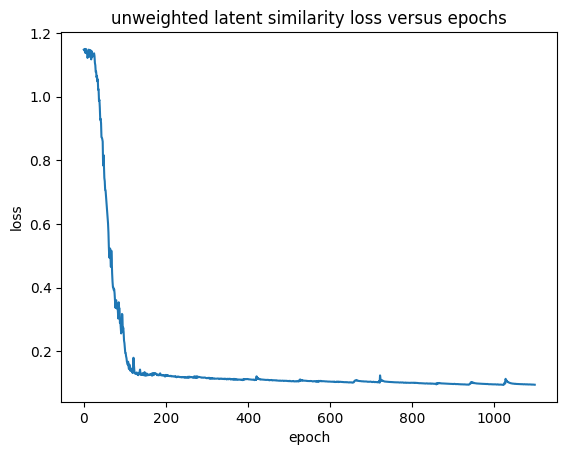

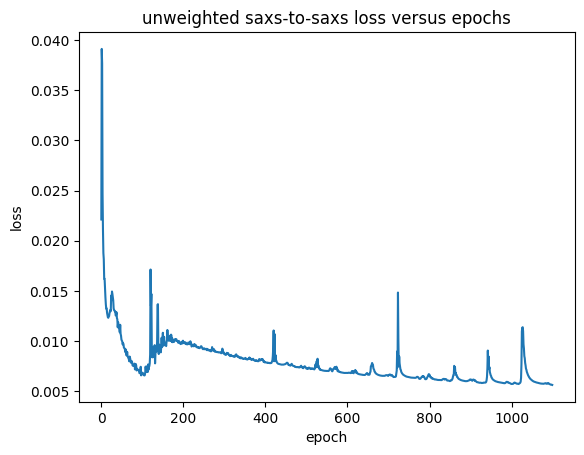

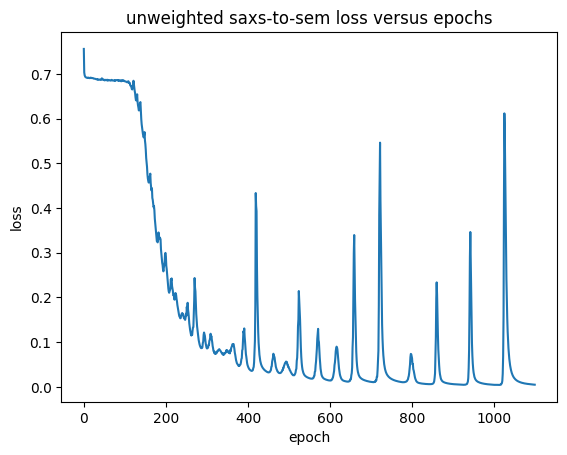

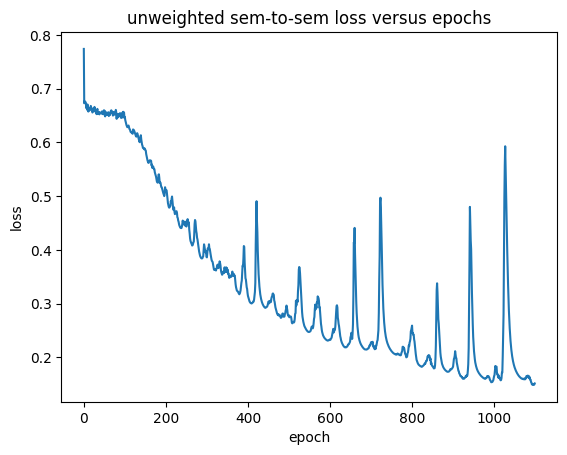

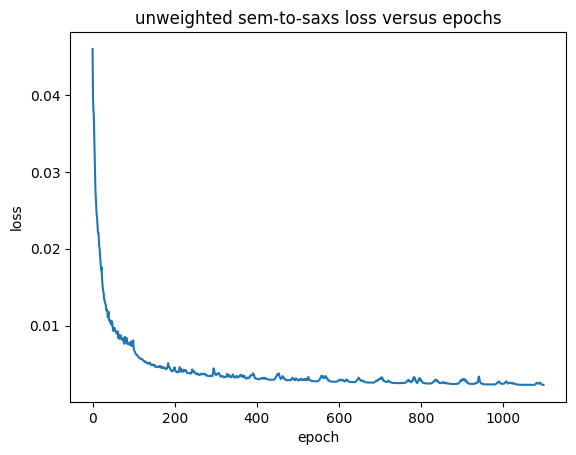

In [ ]:
plt.figure()
plt.plot(sim_loss)
plt.title("unweighted latent similarity loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(saxs_saxs_loss)
plt.title("unweighted saxs-to-saxs loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(saxs_sem_loss)
plt.title("unweighted saxs-to-sem loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(sem_sem_loss)
plt.title("unweighted sem-to-sem loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(sem_saxs_loss)
plt.title("unweighted sem-to-saxs loss versus epochs")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## TSNE of pair trained latents

In [ ]:
paired_sem_latent = vae_sem_encoder.predict(sem_image_holder, batch_size=4)
paired_saxs_latent = vae_saxs_encoder.predict(saxs_image_holder, batch_size=4)

paired_sem_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(np.reshape(paired_sem_latent, (paired_sem_latent.shape[0], paired_sem_latent.shape[1] * paired_sem_latent.shape[2] * paired_sem_latent.shape[3])))
paired_saxs_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(np.reshape(paired_saxs_latent, (paired_saxs_latent.shape[0], paired_saxs_latent.shape[1] * paired_saxs_latent.shape[2] * paired_saxs_latent.shape[3])))

18/18 [==============================] - 7s 410ms/step


In [ ]:
# plot the tsne plot with saxs images
fig, ax = plt.subplots(figsize=(60, 60))
artists = []

visualize_scatter_with_saxs_images(paired_saxs_tsne, saxs_image_file_list, ax, image_zoom=1.00, boxthickness=8)

ax.autoscale()
plt.show()

# plot the tsne plot with cropped sem images (upper left corner (sem_imageSize, sem_imageSize))
fig, ax = plt.subplots(figsize=(60, 60))
artists = []

visualize_scatter_with_sem_images(paired_sem_tsne, sem_image_file_list, ax, image_zoom=1.00, boxthickness=8)

ax.autoscale()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Check cross prediction performances

0.03544452786315303

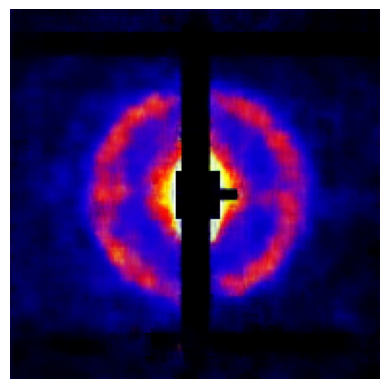

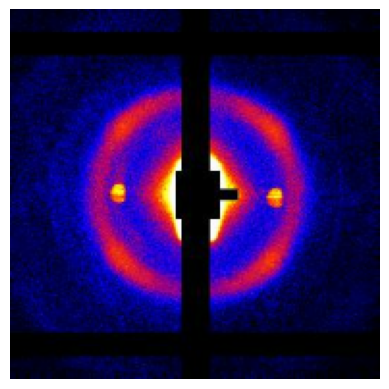

In [32]:
image_stack = saxs_vae(saxs_image_validation[:24])

image_index = 21

plt.imshow(image_stack[image_index], cmap='gray')
plt.axis('off')

plt.figure()
plt.imshow(saxs_image_validation[image_index], cmap='gray')
plt.axis('off')

mean_absolute_error(np.reshape(image_stack[image_index], -1), np.reshape(saxs_image_validation[image_index], -1))

(-0.5, 191.5, 191.5, -0.5)

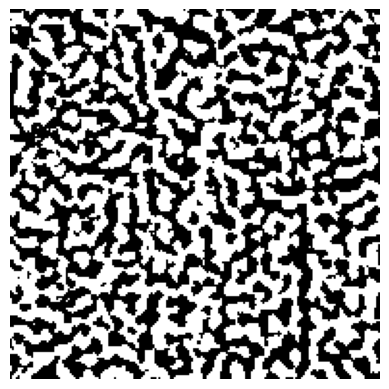

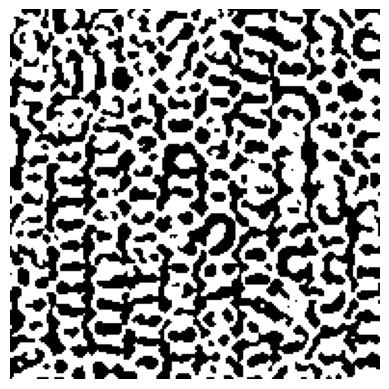

In [33]:
image_stack = vae_sem_decoder(vae_saxs_encoder(saxs_image_validation[:24]))

image_index = 8

plt.imshow(image_stack[image_index], cmap='gray')
plt.axis('off')

plt.figure()
plt.imshow(sem_image_validation_2d[image_index], cmap='gray')
plt.axis('off')

(-0.5, 191.5, 191.5, -0.5)

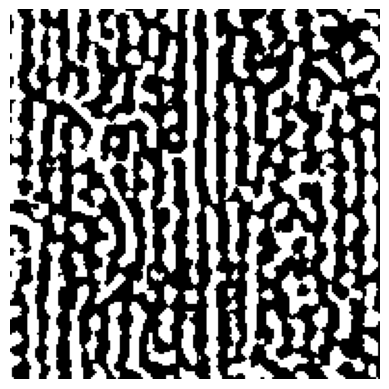

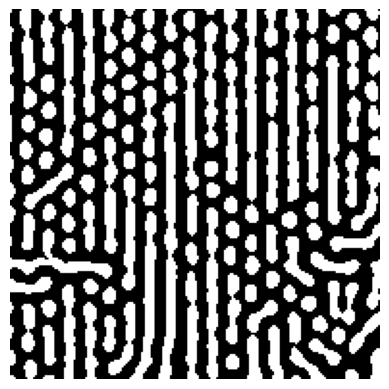

In [34]:
image_stack = sem_vae(sem_image_validation[:24])

image_index = 2

plt.imshow(image_stack[image_index], cmap='gray')
plt.axis('off')

plt.figure()
plt.imshow(sem_image_validation_2d[image_index], cmap='gray')
plt.axis('off')

0.028057927217212338

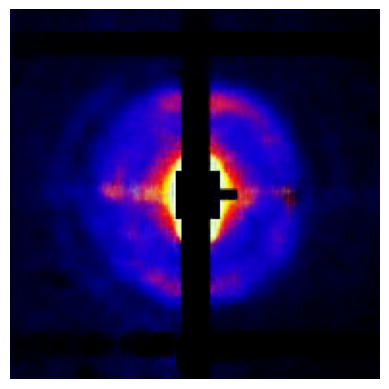

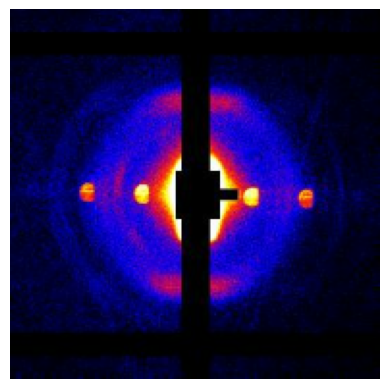

In [35]:
image_stack = vae_saxs_decoder(vae_sem_encoder(sem_image_validation[:24]))

image_index = 8

plt.imshow(image_stack[image_index], cmap='gray')
plt.axis('off')

plt.figure()
plt.imshow(saxs_image_validation[image_index], cmap='gray')
plt.axis('off')

mean_absolute_error(np.reshape(image_stack[image_index], -1), np.reshape(saxs_image_validation[image_index], -1))

In [36]:
pair_trained_encoding_from_saxs = vae_saxs_encoder(saxs_image_holder)
pair_trained_encoding_from_saxs_mean = tf.math.reduce_mean(pair_trained_encoding_from_saxs, axis=0)
pair_trained_encoding_from_saxs_std = tf.math.reduce_std(pair_trained_encoding_from_saxs, axis=0)
pair_trained_encoding_from_sem = vae_sem_encoder(sem_image_holder)
pair_trained_encoding_from_sem_mean = tf.math.reduce_mean(pair_trained_encoding_from_sem, axis=0)
pair_trained_encoding_from_sem_std = tf.math.reduce_std(pair_trained_encoding_from_sem, axis=0)

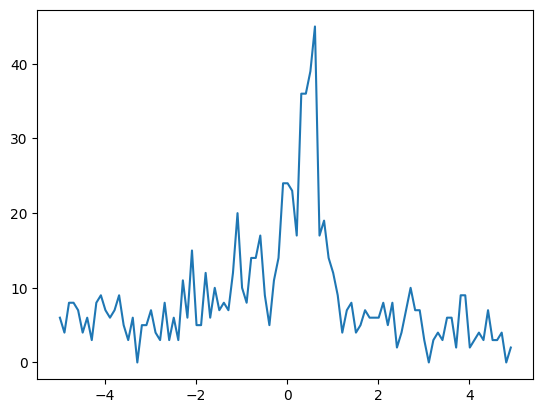

In [37]:
occurances, values = np.histogram(pair_trained_encoding_from_sem_mean.numpy(), bins=100, range=(-5, 5))
plt.plot(values[:-1] + 0.01, occurances)

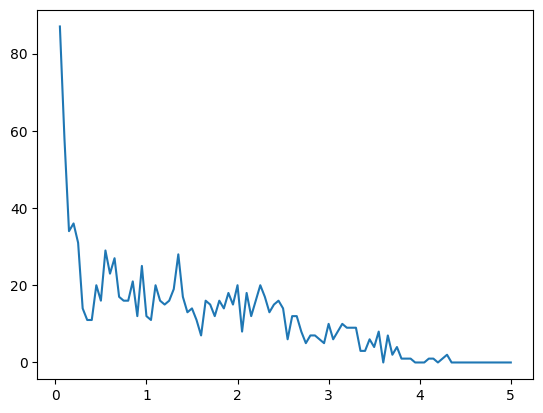

In [38]:
occurances, values = np.histogram(pair_trained_encoding_from_sem_std.numpy(), bins=100, range=(0, 5))
plt.plot(values[:-1] + 0.05, occurances)

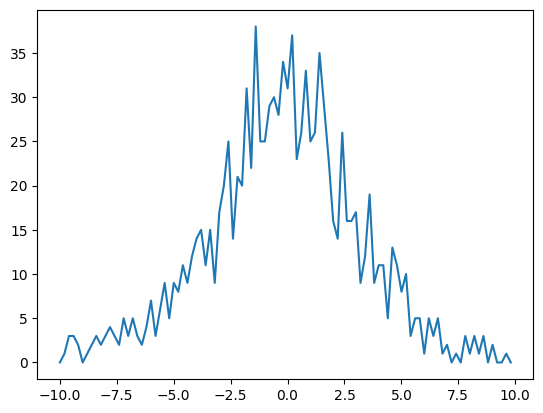

In [39]:
occurances, values = np.histogram(pair_trained_encoding_from_saxs_mean.numpy(), bins=100, range=(-10, 10))
plt.plot(values[:-1] + 0.005, occurances)

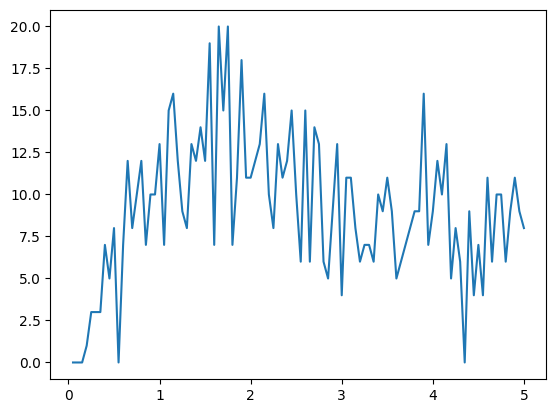

In [40]:
occurances, values = np.histogram(pair_trained_encoding_from_saxs_std.numpy(), bins=100, range=(0, 5))
plt.plot(values[:-1] + 0.05, occurances)